In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("/kaggle/input/titanic/train.csv", header=None)
#print(df)  #Will add the first row as a header  
df.columns = df.iloc[0]
df = df[1:]

test=pd.read_csv("/kaggle/input/titanic/test.csv", header=None)
test.columns = test.iloc[0]
test = test[1:]
test_ids = test["PassengerId"]  #will use this column to make a submission csv later

print(df.head())
print(df.info())

"""
Notes: 
1. Non-numerical data must be converted into numerical
2. Cabin column is mostly empty
3. Age and Embarked columns will need their missing values to be filled
4. Convert Dtypes from object to numerical

"""

0 PassengerId Survived Pclass  \
1           1        0      3   
2           2        1      1   
3           3        1      3   
4           4        1      1   
5           5        0      3   

0                                               Name     Sex Age SibSp Parch  \
1                            Braund, Mr. Owen Harris    male  22     1     0   
2  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38     1     0   
3                             Heikkinen, Miss. Laina  female  26     0     0   
4       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35     1     0   
5                           Allen, Mr. William Henry    male  35     0     0   

0            Ticket     Fare Cabin Embarked  
1         A/5 21171     7.25   NaN        S  
2          PC 17599  71.2833   C85        C  
3  STON/O2. 3101282    7.925   NaN        S  
4            113803     53.1  C123        S  
5            373450     8.05   NaN        S  
<class 'pandas.core.frame.DataFrame'>
RangeI

'\nNotes: \n1. Non-numerical data must be converted into numerical\n2. Cabin column is mostly empty\n3. Age and Embarked columns will need their missing values to be filled\n4. Convert Dtypes from object to numerical\n\n'

In [3]:
def clean(df):
    
    
    #Dropping PassengerId and Ticket since they probably do not have anything to do with whether someone survived or not.
    #Dropping the Cabin column as well, since most of it is empty
    
    df = df.drop(["PassengerId", "Cabin", "Ticket"], axis=1)

  
    #Names themselves dont mean anything but a title can be extracted by some names, which could have some significance 
    #Replacing names with titles where a title can be found, otherwise with "other"
    
    df["Title"] = df["Name"].str.extract(r" ([A-Za-z]+)\.")
    unique_titles = np.setdiff1d(df["Title"], ["Mr", "Miss", "Mrs", "Master"]).tolist()
    df["Title"] = df["Title"].replace(unique_titles, "Other")

    df = df.drop(["Name"], axis=1)


    #SibSp and Parch describe whether or not a person has family or spouses onboard with them
    #This can be replaced by a single column that states if a person is alone or not
    
    df['SibSp'] = df['SibSp'].astype(int)  #first the numbers are converted into integer types
    df['Parch'] = df['Parch'].astype(int) 

    df['Alone'] = np.where((df['SibSp'] == 0) & (df['Parch'] == 0), 1, 0)
    df = df.drop(['Parch','SibSp' ], axis=1)


    #Encoding categorical data into numerical with LabelEncoder
    
    le=preprocessing.LabelEncoder()
    cols = ["Sex", "Embarked", "Title"]

    for col in cols: 
        df[col]= le.fit_transform(df[col])


    #Imputing missing values from age with KNNImputer 
    
    imputer = KNNImputer(n_neighbors=5) #using the default KNN value
    imputed_values = imputer.fit_transform(df[["Age"]])
    imputed_df = pd.DataFrame(imputed_values, columns=["Age"])
    imputed_df = imputed_df[2:]
    df_combined = pd.concat([df.drop("Age", axis=1), imputed_df], axis=1)
    df = df_combined
    df["Age"].fillna(df["Age"].median(), inplace=True)
    df['Age'] = df['Age'].astype(float)

    
    #Replacing the Fare column with its logarithm
    
    df['Fare'] = df['Fare'].astype(float)
    non_zero_values = df['Fare'][df['Fare'] != 0]
    df['log_Fare'] = 0 
    df.loc[df['Fare'] != 0, 'log_Fare'] = np.log(non_zero_values)
    
    df = df.drop(['Fare' ], axis=1)
    
    
    #Data normalization 
    
    cols = ['log_Fare']
    scaler = StandardScaler()
    df[cols] = pd.DataFrame(scaler.fit_transform(df[cols]))
    
    #2 missing values from log_Fare are imputed with the median 
    
    df['log_Fare'].fillna(df['log_Fare'].median(), inplace=True)
    
    
    return df

df=clean(df)
test=clean(test)

df=df.astype(float)
test=test.astype(float)

print(df.info())
print(test.info())

y = df["Survived"]
X = df.drop(["Survived"], axis=1)

"""
Converting all dataframe columns to int or float type(here float) so that 
they can be used by the models
"""



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    891 non-null    float64
 2   Sex       891 non-null    float64
 3   Embarked  891 non-null    float64
 4   Title     891 non-null    float64
 5   Alone     891 non-null    float64
 6   Age       891 non-null    float64
 7   log_Fare  891 non-null    float64
dtypes: float64(8)
memory usage: 55.8 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 1 to 418
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    float64
 1   Sex       418 non-null    float64
 2   Embarked  418 non-null    float64
 3   Title     418 non-null    float64
 4   Alone     418 non-null    float64
 5   Age       418 non-null    float64
 6   log_Fare  418 non-null    float64
dtype

'\nConverting all dataframe columns to int or float type(here float) so that \nthey can be used by the models\n'

"  \nHeatmap shows strongest correlation between survival and the passenger's sex, their class,\nwhether they were alone or not and where they embarked\n"

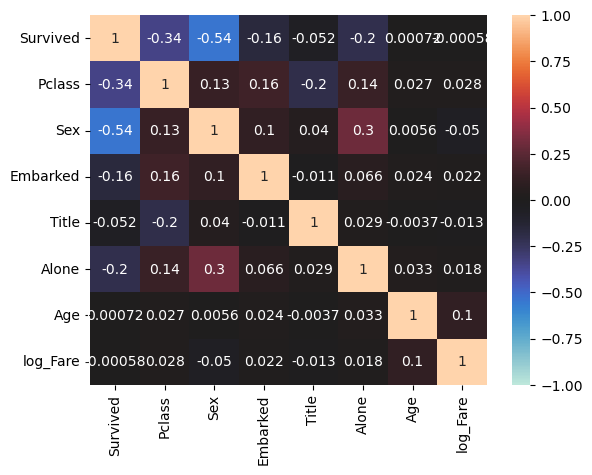

In [4]:
sns.heatmap(data=df.corr(),vmax=1,vmin=-1,center=0,annot=True)

"""  
Heatmap shows strongest correlation between survival and the passenger's sex, their class,
whether they were alone or not and where they embarked
"""


In [5]:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import optuna

"""
Model notes: 

1. Optuna library is used for hyperparameter tuning. 
2. Classification model he is GradientBoostingClassifier
3. The number of trials is chosen after experimentation
"""


def objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 100),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.1),
        
    }
    

    rf = sklearn.ensemble.GradientBoostingClassifier(**params)

    score = cross_val_score(rf, X, y, n_jobs=1, cv=3)
    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)


#Disabling logging as it ends up printing a lot 

optuna.logging.set_verbosity(optuna.logging.WARN) 

In [6]:
trial = study.best_trial
model = GradientBoostingClassifier(**trial.params)
model.fit(X,y)

GradientBoostingClassifier(learning_rate=0.0639364040306979, max_depth=4,
                           max_features='sqrt', max_leaf_nodes=78,
                           min_impurity_decrease=0.085589306903519,
                           min_samples_leaf=3, min_samples_split=9,
                           n_estimators=412, subsample=0.8901574891585692)

In [7]:
submission_preds = model.predict(test)
submission_preds=submission_preds.astype(int)
df = pd.DataFrame({"PassengerId": test_ids.values,
                   "Survived" : submission_preds})
df.to_csv("/kaggle/working/submission.csv", index=False)